In [1]:
%load_ext autoreload
%autoreload 2

# import functions

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import importlib
import copy
import pandas as pd
from scipy import ndimage

import module.dpc as DPC
import module.blc as BLC

# ImageInfo Class

In [3]:
class ImageInfo:
    def __init__(self, image, domain, bayerPattern, bitNumber) -> None:
        self.image = image
        self.domain = domain
        self.bayerPattern = bayerPattern
        self.bitNumber = bitNumber # bitNumber == -1 means the grayscale in (0,1)
        
    def to_raw(self):
        if self.domain != 'RAW':
            print('Error: Not Raw')
            return
        if type(self.image) is not dict: return
        raw4ChDict = self.image
        img = np.empty( np.array(raw4ChDict['R'].shape)*2 , dtype= raw4ChDict['R'].dtype)
        np.repeat(3, 4)
        match self.bayerPattern:
            case 'RGGB':
                img[::2,::2]   = raw4ChDict['R']
                img[::2,1::2]  = raw4ChDict['Gr']
                img[1::2,::2]  = raw4ChDict['Gb']
                img[1::2,1::2] = raw4ChDict['B']
            case 'BGGR':
                img[::2,::2]   = raw4ChDict['B']
                img[::2,1::2]  = raw4ChDict['Gb']
                img[1::2,::2]  = raw4ChDict['Gr']
                img[1::2,1::2] = raw4ChDict['R']
            case 'GBRG':
                img[::2,::2]   = raw4ChDict['Gb']
                img[::2,1::2]  = raw4ChDict['B']
                img[1::2,::2]  = raw4ChDict['R']
                img[1::2,1::2] = raw4ChDict['Gr']
            case 'GRBG':
                img[::2,::2]   = raw4ChDict['Gr']
                img[::2,1::2]  = raw4ChDict['R']
                img[1::2,::2]  = raw4ChDict['B']
                img[1::2,1::2] = raw4ChDict['Gb']
        self.image = img
        
    def to_4ChDict(self):
        if self.domain != 'RAW':
            print('Error: Not Raw')
            return
        if type(self.image) is dict: return
        img = self.image
        match self.bayerPattern:
            case 'RGGB':
                output = {'R' : img[::2,::2],
                        'Gr': img[::2,1::2],
                        'Gb': img[1::2,::2],
                        'B' : img[1::2,1::2]}
            case 'BGGR':
                output = {'B' : img[::2,::2],
                        'Gb': img[::2,1::2],
                        'Gr': img[1::2,::2],
                        'R' : img[1::2,1::2]}
            case 'GBRG':
                output = {'Gb': img[::2,::2],
                        'B' : img[::2,1::2],
                        'R' : img[1::2,::2],
                        'Gr': img[1::2,1::2]}
            case 'GRBG':
                output = {'Gr': img[::2,::2],
                        'R' : img[::2,1::2],
                        'B' : img[1::2,::2],
                        'Gb': img[1::2,1::2]}
        self.image = output
        
    def plot(self):
        self.to_raw()
        plt.imshow(self.image, vmin = 0, vmax=2**self.bitNumber-1, cmap='gray')

# Raw Domain
dtype: np.uint16

## Load RAW

In [4]:
rawInfo = {"path": './raw/DNP.raw',
           "shape": [3120, 4160],
           "bayer pattern": 'BGGR',
           "bit number": 10}

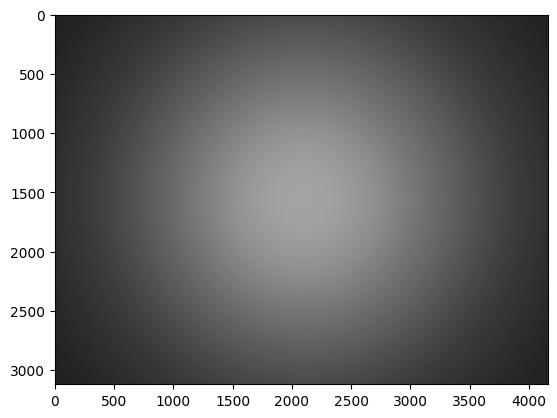

In [5]:
rawImg = np.fromfile(rawInfo['path'], dtype='uint16', sep='')
rawImg = rawImg.reshape(rawInfo["shape"])
rawImage = ImageInfo(rawImg, 'RAW', rawInfo["bayer pattern"], rawInfo["bit number"])
rawImage.plot()

## dead pixel correction

In [6]:
threshold = 10  
mode = 'nearest'
# upLimit = 2**rawInfo["bit number"]-1

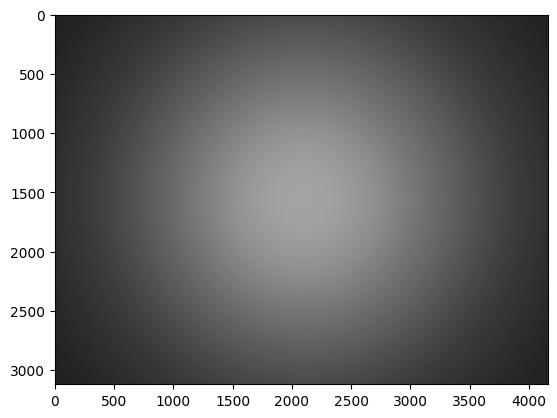

In [7]:
dpcImage = DPC.execute(rawImage, threshold, mode)
dpcImage.plot()

## black level compensation

In [8]:
parameters = [8]*6 # [bl_r, bl_gr, bl_gb, bl_b, alpha, beta]

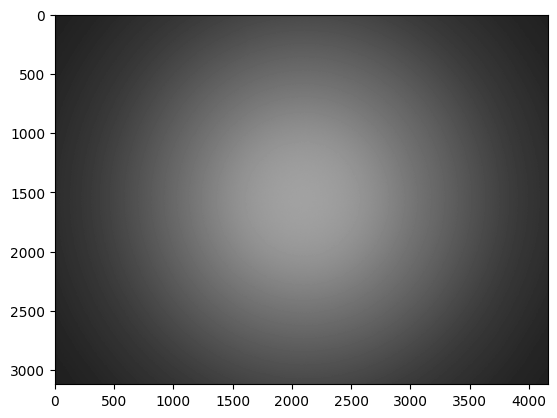

In [9]:
blcImage = BLC.execute(dpcImage, parameters)
blcImage.plot()

# AWB

In [11]:
def AWB_Qual(imageInfo):
    imageInfo.to_4ChDict()
    
    upY    = imageInfo.image['R'].shape[0]//2 - imageInfo.image['R'].shape[0]//16
    downY  = imageInfo.image['R'].shape[0]//2 + imageInfo.image['R'].shape[0]//16
    leftX  = imageInfo.image['R'].shape[1]//2 - imageInfo.image['R'].shape[1]//16
    rightY = imageInfo.image['R'].shape[1]//2 + imageInfo.image['R'].shape[1]//16
    
    R  = np.mean(imageInfo.image['R'][upY:downY,leftX:rightY])
    Gr = np.mean(imageInfo.image['Gr'][upY:downY,leftX:rightY]) 
    Gb = np.mean(imageInfo.image['Gb'][upY:downY,leftX:rightY])
    B  = np.mean(imageInfo.image['B'][upY:downY,leftX:rightY])
    
    AWBData = pd.DataFrame()
    AWBData["RG"] = [2*R/(Gr+Gb)]
    AWBData["BG"] = [2*B/(Gr+Gb)]
    AWBData["GrGb"] = [Gr/Gb]
    
    return AWBData

def LSC_Qual(imageInfo):
    imageInfo.to_4ChDict()
    
    xStep = np.ceil(imageInfo.image['R'].shape[1]*np.arange(1/17/2, 1/2+1/17,1/17))
    xStep = (np.append(-xStep[::-1],xStep)+imageInfo.image['R'].shape[1]//2).astype(int)
    yStep = np.ceil(imageInfo.image['R'].shape[0]*np.arange(1/13/2, 1/2+1/13,1/13))
    yStep = (np.append(-yStep[::-1],yStep)+imageInfo.image['R'].shape[0]//2).astype(int)
    
    LSCDict = {}
    LSCData = pd.DataFrame()
    for color in imageInfo.image.keys():
        LSCDict[color] = np.empty((13,17))
        img = ndimage.gaussian_filter(imageInfo.image[color], sigma=5)
        for j in range(13):
            for i in range(17):
                LSCDict[color][j,i] = np.mean(img[yStep[j]:yStep[j+1], xStep[i]:xStep[i+1]])
        LSCData[color] = (LSCDict[color]/LSCDict[color][6,8]).flatten().astype(np.float16)
    return LSCData
        

In [12]:
with pd.ExcelWriter('./raw/AWBLSC.xlsx', engine='xlsxwriter') as writer:
    AWB_Qual(blcImage).to_excel(writer, index = False, sheet_name='AWB')
    LSC_Qual(blcImage).to_excel(writer, index = False, sheet_name='LSC')